# 1 Looking at Volume in General

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan


In [2]:
# Looking at events and indices:
file_path = 'D:\GitHub\Equity Project\B Separating Files for Backtest\Index_Event_Data_Before_June_2023.csv'
index_event_data = pd.read_csv(file_path)

# Extract and sort the list of unique indices and actions
indices = sorted(index_event_data['Index Change'].unique())
cleaned_actions = sorted(index_event_data['Action'].unique())
SS
# Create a two-way table (pivot table)
two_way_table = pd.pivot_table(index_event_data, values='Ticker', index='Index Change', columns='Action', aggfunc='count', fill_value=0)

two_way_table.loc['Total',:]= two_way_table.sum(axis=0)
two_way_table.loc[:,'Total'] = two_way_table.sum(axis=1)

# Display the two-way table
print("\nTwo-way table showing the count of entries for each action and index:")
two_way_table


Two-way table showing the count of entries for each action and index:


Action,Add,Delete,Downweight,MSCI SC to Std,SP400 to SP500,SP400 to SP600,SP500 to SP400,SP500 to SP600,SP600 to SP400,Upweight,Total
Index Change,,,,,,,,,,,
MSCI SC,8.0,83.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,120.0,214.0
MSCI Std,2.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0,26.0
Nasdaq 100,8.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
Russell 1000,11.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,60.0
Russell 2000,16.0,68.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,125.0
Russell 3000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
S&P Completion,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
S&P Total Market,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
SP400,36.0,20.0,1.0,0.0,3.0,8.0,4.0,0.0,9.0,16.0,97.0


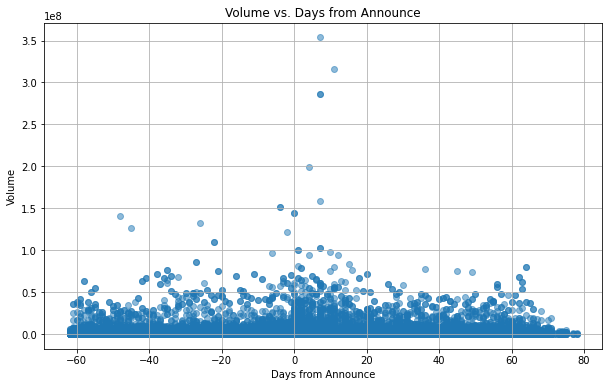

C:\Users\联想\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


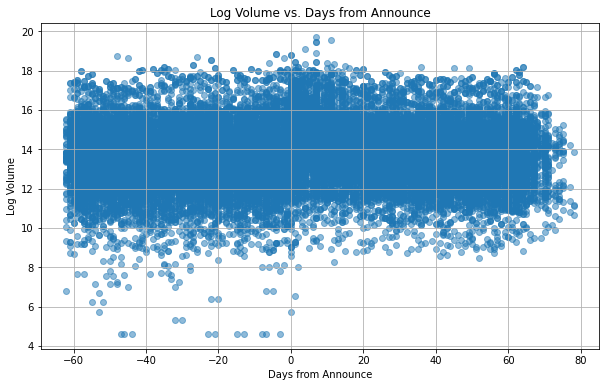

In [48]:
# Load the data
file_path = 'D:\GitHub\Equity Project\B Separating Files for Backtest\Price_data_Before_June_2023.csv'
data = pd.read_csv(file_path)

# Plot the "Volume" variable against the "Days from Announce" variable
plt.figure(figsize=(10, 6))
plt.scatter(data['Days from Announce'], data['Volume'], alpha=0.5)
plt.title('Volume vs. Days from Announce')
plt.xlabel('Days from Announce')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

# Take the log of the volume variable
data['Log Volume'] = np.log(data['Volume'])

# Plot the log of the "Volume" variable against the "Days from Announce" variable
plt.figure(figsize=(10, 6))
plt.scatter(data['Days from Announce'], data['Log Volume'], alpha=0.5)
plt.title('Log Volume vs. Days from Announce')
plt.xlabel('Days from Announce')
plt.ylabel('Log Volume')
plt.grid(True)
plt.show()



We now look at the Log Volumes normalized by their 60-day average in the two months before the announcement: 

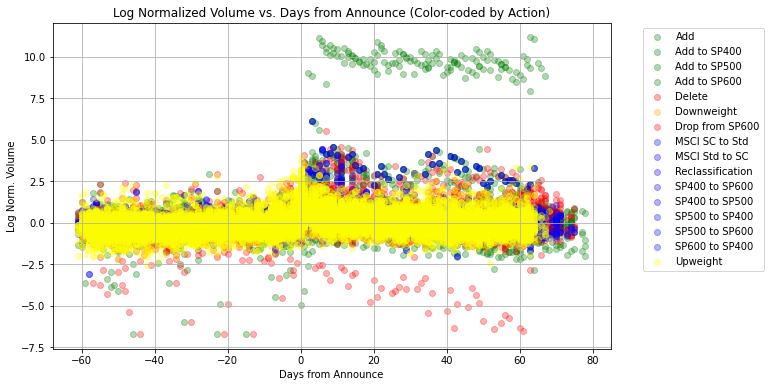

In [49]:
# Filter the data for days before the announcement
before_announcement_data = data[data['Days from Announce'] < 0]

# Group the filtered data by the specified keys and calculate the mean volume
average_volume_before_announcement = before_announcement_data.groupby(['Ticker', 'Action', 'Index', 'Shares Traded']).agg({
    'Volume': 'mean',
    'Open': 'mean',
    'Close': 'mean'
}).reset_index()

# Rename the 'Volume' column to 'Average Volume Before Announcement' for clarity
average_volume_before_announcement = average_volume_before_announcement.rename(columns={'Volume': 'Average Volume Before Announcement'})
average_volume_before_announcement = average_volume_before_announcement.rename(columns={'Open': 'Average Open'})
average_volume_before_announcement = average_volume_before_announcement.rename(columns={'Close': 'Average Close'})

# Take the log of the average volume before the announcement
average_volume_before_announcement['Log Average Volume Before Announcement'] = np.log(average_volume_before_announcement['Average Volume Before Announcement'])
average_volume_before_announcement['Log Average Open'] = np.log(average_volume_before_announcement['Average Open'])
average_volume_before_announcement['Log Average Close'] = np.log(average_volume_before_announcement['Average Close'])

# Merge the log average volume back to the original data
data_merged = data.merge(average_volume_before_announcement, on=['Ticker', 'Action', 'Index', 'Shares Traded'], how='left')

# Subtract the log average volume before the announcement from the log volume of each entry
data_merged['Log Normalized Volume'] = data_merged['Log Volume'] - data_merged['Log Average Volume Before Announcement']
data_merged['Log Normalized Open'] = np.log(data_merged['Open'])-data_merged['Log Average Open']
data_merged['Log Normalized Close'] = np.log(data_merged['Close'])-data_merged['Log Average Close']

# Calculate the daily returns. Note that I use 'Shares Traded' as part of event id, since it seems relatively unique to each event
data_merged['Return'] = data_merged.groupby(['Ticker', 'Index', 'Shares Traded'])['Close'].pct_change()

# Create the binary variable for announcement effect only, and for after trade occurs
data_merged['Days from Announce Binary'] = (data_merged['Days from Announce'] >= 0).astype(int)
data_merged['Days from Trade Binary'] = (data_merged['Days from Trade']>=0).astype(int)

data_merged = data_merged.dropna(subset=['Return', 'Log Normalized Volume'])

# Display the first few rows of the resulting dataframe
#print(data_merged.head())

# Define colors for each action
action_colors = {
     'Add': 'green',
     'Add to SP400': 'green',
     'Add to SP500': 'green',
     'Add to SP600': 'green',
     'Delete': 'red',
     'Downweight': 'orange',
     'Drop from SP600': 'red',
     'MSCI SC to Std': 'blue',
     'MSCI Std to SC': 'blue',
     'Reclassification': 'blue',
     'SP400 to SP600': 'blue',
     'SP400 to SP500': 'blue',
     'SP400 to SP600': 'blue',
     'SP500 to SP400': 'blue',
     'SP500 to SP600': 'blue',
     'SP600 to SP400': 'blue',
     'Upweight': 'yellow'
}

# Plot the log volume difference, color-coded by action
plt.figure(figsize=(10, 6))
for action, color in action_colors.items():
    subset = data_merged[data_merged['Action'] == action]
    plt.scatter(subset['Days from Announce'], subset['Log Normalized Volume'], alpha=0.3, label=action, color=color)

plt.title('Log Normalized Volume vs. Days from Announce (Color-coded by Action)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Norm. Volume')
plt.grid(True)

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
# # Save the cleaned dataframe to a CSV file for further analysis
# #data_merged.to_csv('cleaned_data_volume_difference.csv', index=False)
# data_merged[data_merged['Log Normalized Volume']>7].to_csv('strange_volumes.csv',index=False)



It seems that entries with "Add" and "Delete" action seems in general to have greater variance in volume after announcement.
This motivates looking into the action "Add", and examining each actions separately in general.

# 2 Volume and Price Changes Due to "Add"

We now focus on the subset of entries associated with the action "Add".
The group of outliers shown in the original graph is due to a single spin-off event for XPER.
In the ensuing section, we remove this outlier.

Here is the Normalized Volume and Close price mapped against Days from Announce:
(It warrants to look at how different indices impact price and volume, so they are color coded)

We also create the two binary variables, "Days from Announce Binary" and "Days from Trade Binary", here.
"Days from Announce Binary" takes the value 1 for days after announcement, but before trade. 0 otherwise.
"Days from Trade Binary" takes the value 1 after the trade. 0 otherwise

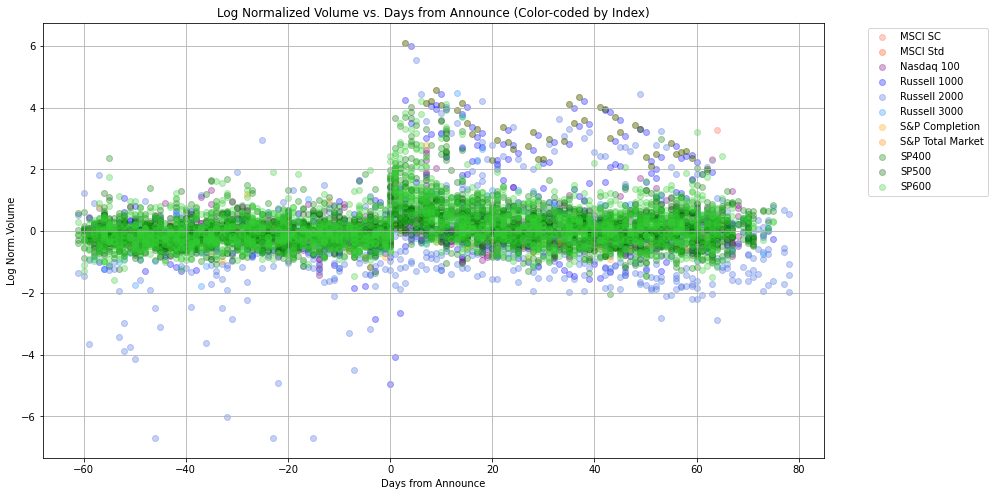

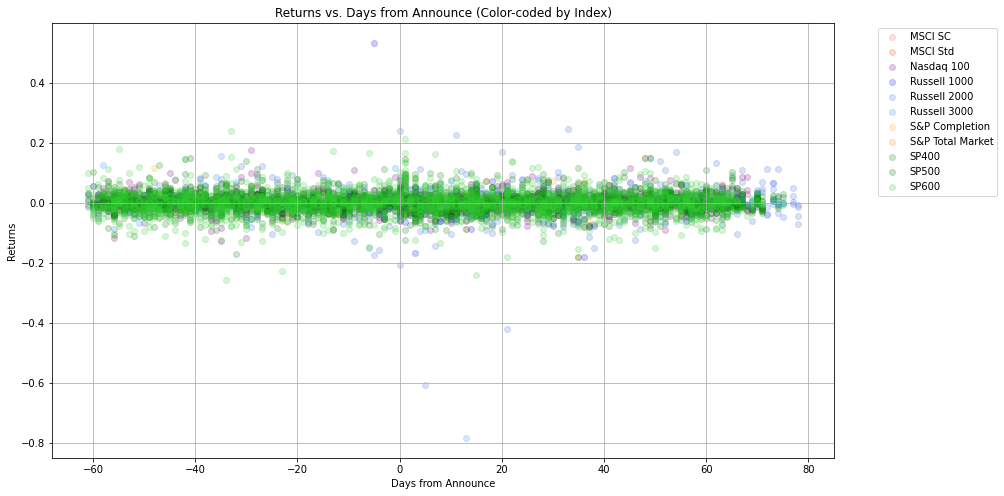

<Figure size 1008x576 with 0 Axes>

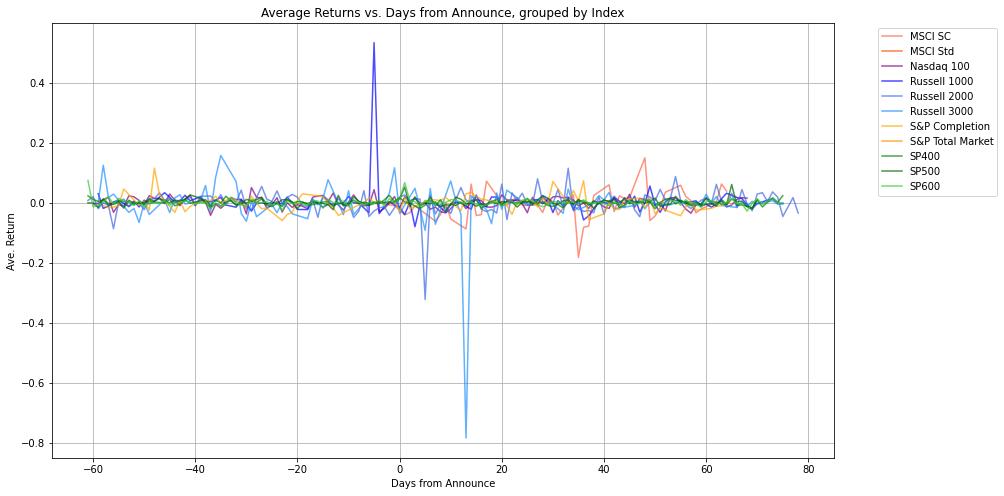

In [54]:
data_add_only = data_merged[data_merged['Action'] == 'Add']
data_add_only = data_add_only[data_add_only['Ticker'] != 'XPER']
data_add_only = data_add_only.replace([np.inf, -np.inf], np.nan).dropna()
# Plot the log volume difference, color-coded by indices
# Define colors for each indices
# Define colors for each index
index_colors = {
    'MSCI SC': '#FF6347',  # tomato red
    'MSCI Std': '#FF4500',  # orange red
    'Nasdaq 100': '#800080',  # purple
    'Russell 1000': '#0000FF',  # blue
    'Russell 2000': '#4169E1',  # royal blue
    'Russell 3000': '#1E90FF',  # dodger blue
    'S&P Completion': '#FFA500',  # orange
    'S&P Total Market': '#FF8C00',  # dark orange
    'SP400': '#008000',  # green
    'SP500': '#006400',  # dark green
    'SP600': '#32CD32'  # lime green
}

# Plot the log volume difference, color-coded by indices
plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = data_add_only[data_add_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Log Normalized Volume'], alpha=0.3, label=index, color=color)

plt.title('Log Normalized Volume vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Norm.Volume')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot the Returns, color-coded by indices
plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = data_add_only[data_add_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Return'], alpha=0.2, label=index, color=color)
plt.title('Returns vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Returns')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot Returns for each ticker over time
plt.figure(figsize=(14, 8))

# # Group by Ticker and plot each one
# for ticker, group_data in data_add_only.groupby('Ticker'):
#     plt.plot(group_data['Days from Announce'], group_data['Return'], label=ticker)

# plt.title('Return Over Time for Each Ticker')
# plt.xlabel('Days from Announce')
# plt.ylabel('Return')
# #plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.show()

#Plot the Average return, grouped by Index
average_returns = data_add_only.groupby(['Index','Days from Announce'])['Return'].mean().reset_index()
# Plot the average returns
plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = average_returns[average_returns['Index'] == index]
    plt.plot(subset['Days from Announce'], subset['Return'], alpha=0.7, label=index, color=color)
plt.title('Average Returns vs. Days from Announce, grouped by Index')
plt.xlabel('Days from Announce')
plt.ylabel('Ave. Return')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()





It seems on the aggregate that "Add" announcements would increase the volume, as well as induce greater price volatility,
but the price level does not uniformly increase. 

Since we essentially have a panel data set, with Ticker as Identity and Days from Announce as time tracker, we can use the fixed effect estimator to estimate the Announcement Effect and Effects from the actual trading:

This model suggest that after announcement, indices either have positive or no effect on price, while price decreases after funds trade for adjustment. 

We also apply this regression with Y='Log Normalized Volume':

In [56]:
# Create dummy variables for each index
index_dummies = pd.get_dummies(data_add_only_price_clean['Index'], prefix='Index')

# Create dummy variables multiplied by 'Days from Announce Binary'
index_dummies_announce = index_dummies.copy()
index_dummies_announce.columns = [col + '_Announce' for col in index_dummies_announce.columns]
for col in index_dummies_announce.columns:
    index_dummies_announce[col] = index_dummies[col.replace('_Announce', '')] * data_add_only_price_clean['Days from Announce Binary']

# Create dummy variables multiplied by 'Days from Trade Binary'
index_dummies_trade = index_dummies.copy()
index_dummies_trade.columns = [col + '_Trade' for col in index_dummies_trade.columns]
for col in index_dummies_trade.columns:
    index_dummies_trade[col] = index_dummies[col.replace('_Trade', '')] * data_add_only_price_clean['Days from Trade Binary']


In [58]:
# Define the dependent and independent variables for Log Normalized Volume
y_close = data_add_only_price_clean['Log Normalized Close']
X_close = pd.concat([index_dummies_announce, index_dummies_trade], axis=1)

# Fit the fixed effects model for Log Normalized Volume
model_volume = PanelOLS(y_volume, X_close, entity_effects=True)
results_volume = model_volume.fit()

print(results_volume)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Log Normalized Close   R-squared:                        0.0370
Estimator:                     PanelOLS   R-squared (Between):              0.0965
No. Observations:                  7734   R-squared (Within):               0.0370
Date:                  Sun, Aug 04 2024   R-squared (Overall):              0.0640
Time:                          10:25:51   Log-likelihood                    6008.7
Cov. Estimator:              Unadjusted                                           
                                          F-statistic:                      18.325
Entities:                            87   P-value                           0.0000
Avg Obs:                         88.897   Distribution:                 F(16,7631)
Min Obs:                         45.000                                           
Max Obs:                         183.00   F-statistic (robust):             18.325
    

# 3 Price and Volume Changes Due to "Delete"

In this section, we look at the subset of the data that contains the "Delete" action:

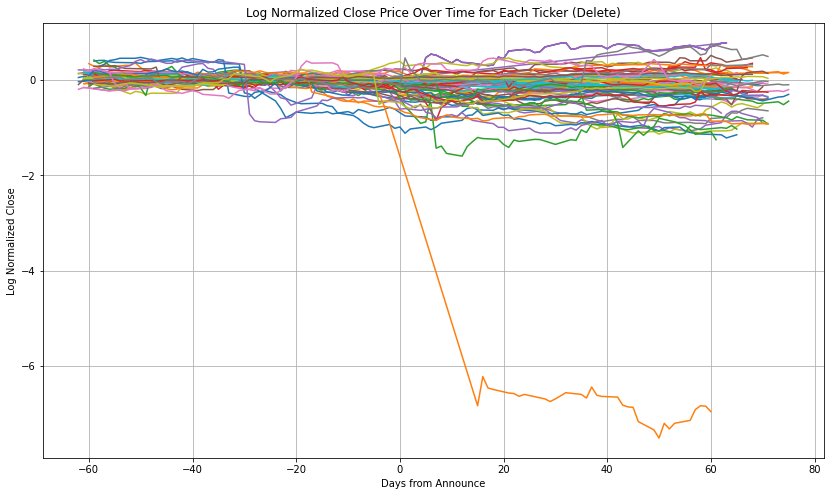

In [13]:
# Filter for 'Delete' actions
data_delete_only = data_merged[data_merged['Action'] == 'Delete']

# Ensure no -inf, NaN, or infinite values in 'Log Normalized Volume' and 'Log Normalized Close'
data_delete_only = data_delete_only.replace([np.inf, -np.inf], np.nan).dropna(subset=['Log Normalized Volume', 'Log Normalized Close'])

# Reset index to plot
data_delete_only = data_delete_only.reset_index()

# Plot log normalized close for each ticker over time
plt.figure(figsize=(14, 8))

# Group by Ticker and plot each one
for ticker, group_data in data_delete_only.groupby('Ticker'):
    plt.plot(group_data['Days from Announce'], group_data['Log Normalized Close'], label=ticker)

plt.title('Log Normalized Close Price Over Time for Each Ticker (Delete)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Normalized Close')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

Here is the same graph, color coded by indices instead:

<Figure size 1008x576 with 0 Axes>

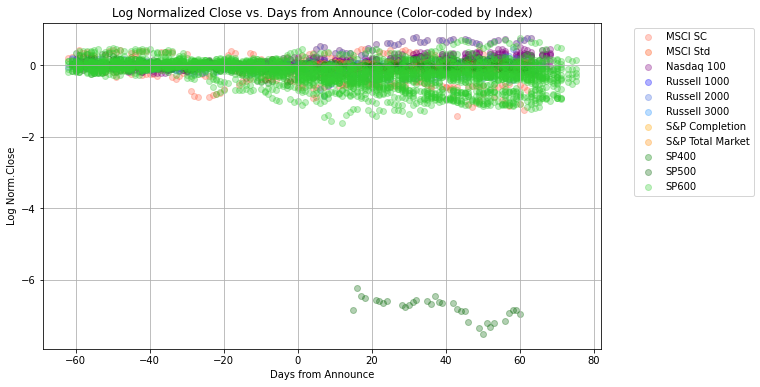

In [14]:
# Define the index colors
index_colors = {
    'MSCI SC': '#FF6347',  # tomato red
    'MSCI Std': '#FF4500',  # orange red
    'Nasdaq 100': '#800080',  # purple
    'Russell 1000': '#0000FF',  # blue
    'Russell 2000': '#4169E1',  # royal blue
    'Russell 3000': '#1E90FF',  # dodger blue
    'S&P Completion': '#FFA500',  # orange
    'S&P Total Market': '#FF8C00',  # dark orange
    'SP400': '#008000',  # green
    'SP500': '#006400',  # dark green
    'SP600': '#32CD32'  # lime green
}

# Plot log normalized close for each ticker over time, color-coded by index
plt.figure(figsize=(14, 8))

# Plot the log volume difference, color-coded by indices
plt.figure(figsize=(10, 6))
for index, color in index_colors.items():
    subset = data_delete_only[data_delete_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Log Normalized Close'], alpha=0.3, label=index, color=color)

plt.title('Log Normalized Close vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Norm.Close')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
Here is the Volume, Color-coded by Index:

<Figure size 1008x576 with 0 Axes>

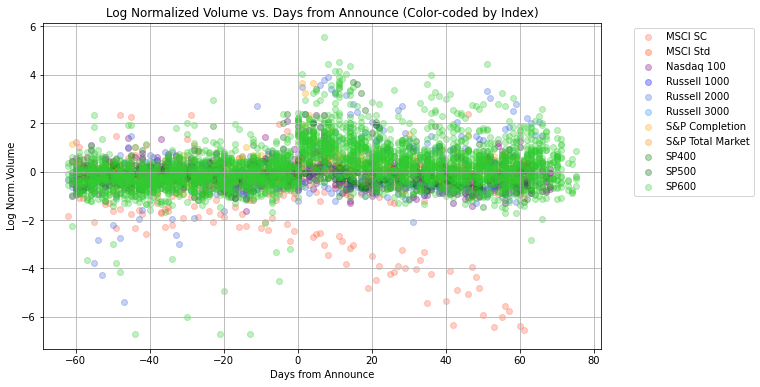

In [15]:
# Plot log normalized close for each ticker over time, color-coded by index
plt.figure(figsize=(14, 8))

# Plot the log volume difference, color-coded by indices
plt.figure(figsize=(10, 6))
for index, color in index_colors.items():
    subset = data_delete_only[data_delete_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Log Normalized Volume'], alpha=0.3, label=index, color=color)

plt.title('Log Normalized Volume vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Norm.Volume')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [16]:
#Note that Price features some outliers, here we find the outliers from data_delete_only
data_delete_only_outlier = data_delete_only[data_delete_only['Log Normalized Close']<-4]
data_delete_only_outlier['Ticker'].unique()

#Of Course, it is the infamous Signature Bank, which went under receivership.

array(['SBNY'], dtype=object)

In [17]:
#Remove the outlier
data_delete_only_price_clean = data_delete_only[~data_delete_only['Ticker'].isin(['SBNY'])]

Here is the Fixed Effect estimator for index-specific Delete Announcement Effect:

In [18]:
# Set the multiindex for panel data
if not {'Ticker', 'Days from Announce'}.issubset(data_delete_only_price_clean.index.names):
    data_delete_only_price_clean = data_delete_only_price_clean.set_index(['Ticker', 'Days from Announce'])

In [19]:
# Create dummy variables for each index
index_dummies = pd.get_dummies(data_delete_only_price_clean['Index'], prefix='Index')

# Create dummy variables multiplied by 'Days from Announce Binary'
index_dummies_announce = index_dummies.copy()
index_dummies_announce.columns = [col + '_Announce' for col in index_dummies_announce.columns]
for col in index_dummies_announce.columns:
    index_dummies_announce[col] = index_dummies[col.replace('_Announce', '')] * data_delete_only_price_clean['Days from Announce Binary']

# Create dummy variables multiplied by 'Days from Trade Binary'
index_dummies_trade = index_dummies.copy()
index_dummies_trade.columns = [col + '_Trade' for col in index_dummies_trade.columns]
for col in index_dummies_trade.columns:
    index_dummies_trade[col] = index_dummies[col.replace('_Trade', '')] * data_delete_only_price_clean['Days from Trade Binary']


In [20]:
# Define the dependent and independent variables for Log Normalized Close
y_close = data_delete_only_price_clean['Log Normalized Close']
# Update X_close to include index_dummies
X_close = pd.concat([index_dummies_announce, index_dummies_trade], axis=1)
X_close = sm.add_constant(X_close)

# Fit the fixed effects model for Log Normalized Close
model_close = PanelOLS(y_close, X_close, entity_effects=True)
results_close = model_close.fit()

print(results_close)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Log Normalized Close   R-squared:                        0.2793
Estimator:                     PanelOLS   R-squared (Between):              0.2564
No. Observations:                  5624   R-squared (Within):               0.2793
Date:                  Fri, Aug 02 2024   R-squared (Overall):              0.2670
Time:                          20:24:07   Log-likelihood                    1206.6
Cov. Estimator:              Unadjusted                                           
                                          F-statistic:                      179.35
Entities:                            58   P-value                           0.0000
Avg Obs:                         96.966   Distribution:                 F(12,5554)
Min Obs:                         41.000                                           
Max Obs:                         259.00   F-statistic (robust):             179.35
    

We note that in contrast to the "Add", most of the indices have negative effects on price after announcing "Delete". Notably, Nasdaq 100 has a positive effect. On the other hand, Deletion from SP 600 seem to have an outsized negative effect on price. But these anomalities may be due to the small sample size and the simplicity of our estimation model.

Below is the Fixed Effect Estimator for Volume:

In [21]:
# Define the dependent and independent variables for Log Normalized Close
y_volume = data_delete_only_price_clean['Log Normalized Volume']

# Fit the fixed effects model for Log Normalized Close
model_volume = PanelOLS(y_volume, X_close, entity_effects=True)
results_volume = model_volume.fit()

print(results_volume)

                            PanelOLS Estimation Summary                            
Dep. Variable:     Log Normalized Volume   R-squared:                        0.1457
Estimator:                      PanelOLS   R-squared (Between):              0.2471
No. Observations:                   5624   R-squared (Within):               0.1457
Date:                   Fri, Aug 02 2024   R-squared (Overall):              0.1719
Time:                           20:26:21   Log-likelihood                   -6338.6
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      78.939
Entities:                             58   P-value                           0.0000
Avg Obs:                          96.966   Distribution:                 F(12,5554)
Min Obs:                          41.000                                           
Max Obs:                          259.00   F-statistic (robust):            

It seems that "Delete" actions coinsides with decline in share value in general

# 4 Price and Volume Changes Due to "Upweight"

In this section, we look at the subset of the data that contains the "Upweight" action:

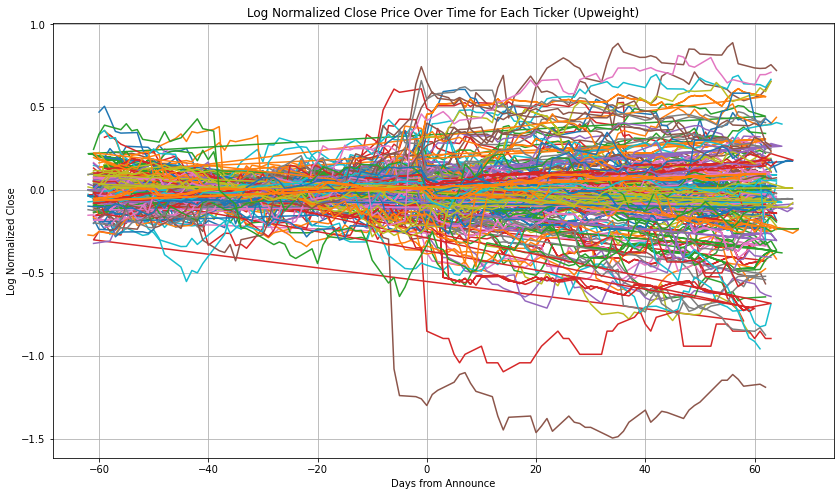

<Figure size 1008x576 with 0 Axes>

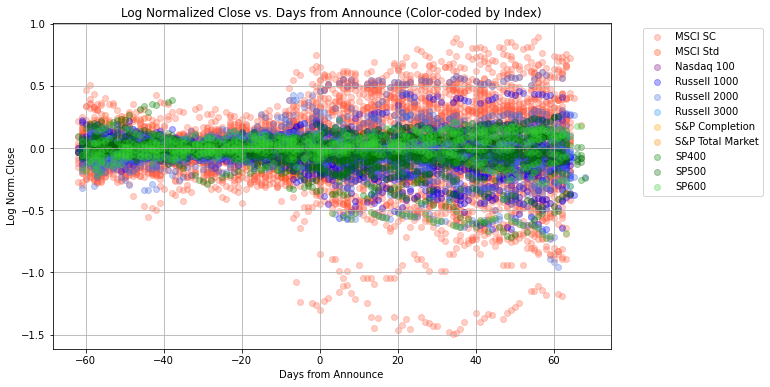

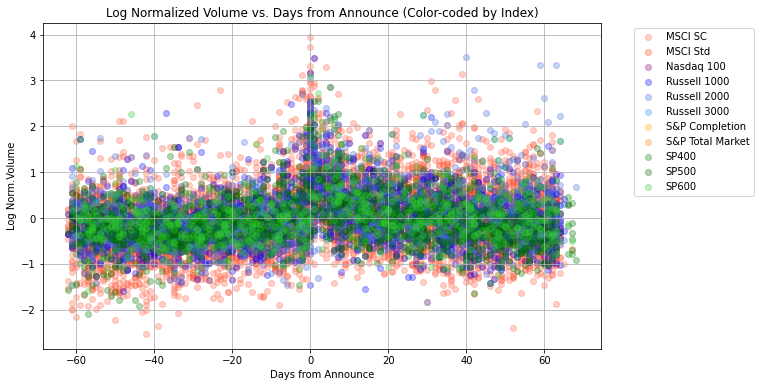

In [22]:
# Filter for 'Upweight' actions
data_up_only = data_merged[data_merged['Action'] == 'Upweight']

# Ensure no -inf, NaN, or infinite values in 'Log Normalized Volume' and 'Log Normalized Close'
data_up_only = data_up_only.replace([np.inf, -np.inf], np.nan).dropna(subset=['Log Normalized Volume', 'Log Normalized Close'])

# Reset index to plot
data_up_only = data_up_only.reset_index()

# Plot log normalized close for each ticker over time
plt.figure(figsize=(14, 8))

# Group by Ticker and plot each one
for ticker, group_data in data_up_only.groupby('Ticker'):
    plt.plot(group_data['Days from Announce'], group_data['Log Normalized Close'], label=ticker)

plt.title('Log Normalized Close Price Over Time for Each Ticker (Upweight)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Normalized Close')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

# Define the index colors
index_colors = {
    'MSCI SC': '#FF6347',  # tomato red
    'MSCI Std': '#FF4500',  # orange red
    'Nasdaq 100': '#800080',  # purple
    'Russell 1000': '#0000FF',  # blue
    'Russell 2000': '#4169E1',  # royal blue
    'Russell 3000': '#1E90FF',  # dodger blue
    'S&P Completion': '#FFA500',  # orange
    'S&P Total Market': '#FF8C00',  # dark orange
    'SP400': '#008000',  # green
    'SP500': '#006400',  # dark green
    'SP600': '#32CD32'  # lime green
}

# Plot log normalized close for each ticker over time, color-coded by index
plt.figure(figsize=(14, 8))

# Plot the log volume difference, color-coded by indices
plt.figure(figsize=(10, 6))
for index, color in index_colors.items():
    subset = data_up_only[data_up_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Log Normalized Close'], alpha=0.3, label=index, color=color)

plt.title('Log Normalized Close vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Norm.Close')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
for index, color in index_colors.items():
    subset = data_up_only[data_up_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Log Normalized Volume'], alpha=0.3, label=index, color=color)

plt.title('Log Normalized Volume vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Norm.Volume')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We find and eliminate the outlier:

In [23]:
data_up_only_outlier = data_up_only[data_up_only['Log Normalized Close']<-1.25]
print(data_up_only_outlier['Ticker'].unique())
#Ticker ESPR, it is an equity offering event

tickers_to_kick = data_up_only_outlier['Ticker'].unique()
data_up_only_price_clean = data_up_only[~data_up_only['Ticker'].isin(tickers_to_kick)]

['ESPR']


Here is the Fixed Effect estimator for index-specific Delete Announcement Effect:

In [24]:
# Set the multiindex for panel data
if not {'Ticker', 'Days from Announce'}.issubset(data_up_only_price_clean.index.names):
    data_up_only_price_clean = data_up_only_price_clean.set_index(['Ticker', 'Days from Announce'])

# Create dummy variables for each index
index_dummies = pd.get_dummies(data_up_only_price_clean['Index'], prefix='Index')

# Create dummy variables multiplied by 'Days from Announce Binary'
index_dummies_announce = index_dummies.copy()
index_dummies_announce.columns = [col + '_Announce' for col in index_dummies_announce.columns]
for col in index_dummies_announce.columns:
    index_dummies_announce[col] = index_dummies[col.replace('_Announce', '')] * data_up_only_price_clean['Days from Announce Binary']

# Create dummy variables multiplied by 'Days from Trade Binary'
index_dummies_trade = index_dummies.copy()
index_dummies_trade.columns = [col + '_Trade' for col in index_dummies_trade.columns]
for col in index_dummies_trade.columns:
    index_dummies_trade[col] = index_dummies[col.replace('_Trade', '')] * data_up_only_price_clean['Days from Trade Binary']

In [25]:
# Define the dependent and independent variables for Log Normalized Close
y_close = data_up_only_price_clean['Log Normalized Close']
# Update X_close to include index_dummies
X_close = pd.concat([index_dummies_announce, index_dummies_trade], axis=1)
X_close = sm.add_constant(X_close)

# Fit the fixed effects model for Log Normalized Close
model_close = PanelOLS(y_close, X_close, entity_effects=True)
results_close = model_close.fit()

print(results_close)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Log Normalized Close   R-squared:                        0.0092
Estimator:                     PanelOLS   R-squared (Between):              0.0084
No. Observations:                 17991   R-squared (Within):               0.0092
Date:                  Fri, Aug 02 2024   R-squared (Overall):              0.0099
Time:                          20:27:15   Log-likelihood                    8202.2
Cov. Estimator:              Unadjusted                                           
                                          F-statistic:                      11.849
Entities:                           142   P-value                           0.0000
Avg Obs:                         126.70   Distribution:                F(14,17835)
Min Obs:                         82.000                                           
Max Obs:                         423.00   F-statistic (robust):             11.849
    

We see small decease in normalized price after annoucement, while there does not seem to be a recovery process within two months. This may be due to longer trading cycles. 

In [26]:
# Define the dependent and independent variables for Log Normalized Volume
y_volume = data_up_only_price_clean['Log Normalized Volume']

# Fit the fixed effects model for Log Normalized Close
model_volume = PanelOLS(y_volume, X_close, entity_effects=True)
results_volume = model_volume.fit()

print(results_volume)

                            PanelOLS Estimation Summary                            
Dep. Variable:     Log Normalized Volume   R-squared:                        0.1384
Estimator:                      PanelOLS   R-squared (Between):             -0.0128
No. Observations:                  17991   R-squared (Within):               0.1384
Date:                   Fri, Aug 02 2024   R-squared (Overall):              0.1198
Time:                           20:29:15   Log-likelihood                  -1.4e+04
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      204.58
Entities:                            142   P-value                           0.0000
Avg Obs:                          126.70   Distribution:                F(14,17835)
Min Obs:                          82.000                                           
Max Obs:                          423.00   F-statistic (robust):            

We see an uptick in volume after announcement, and decrease in volume after trading.

# 5 Price and Volume Changes Due to "Downweight"

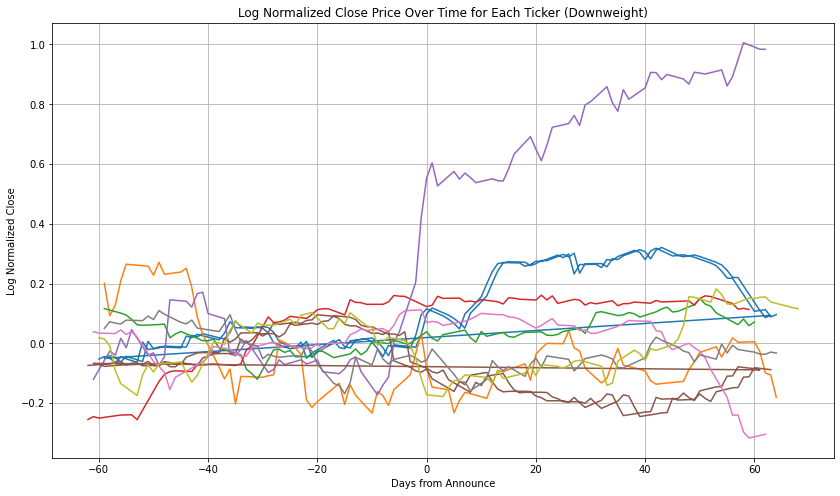

<Figure size 1008x576 with 0 Axes>

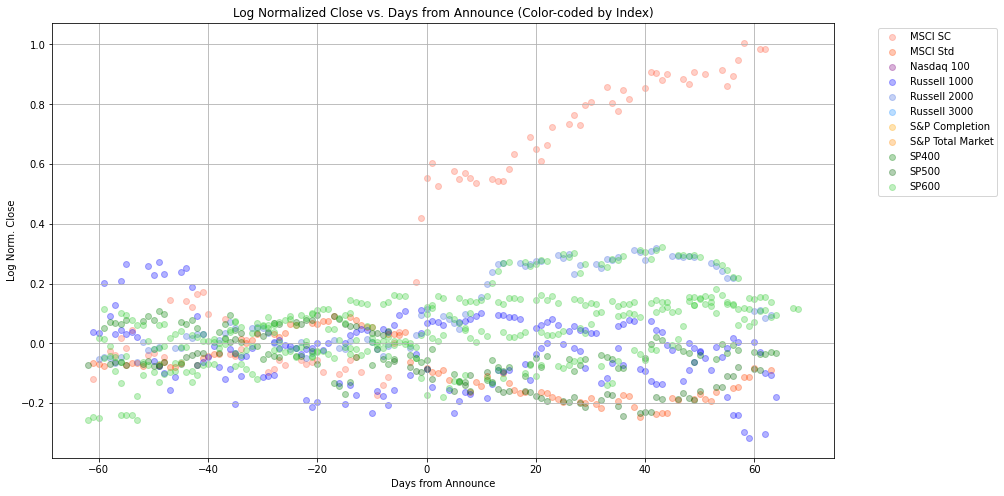

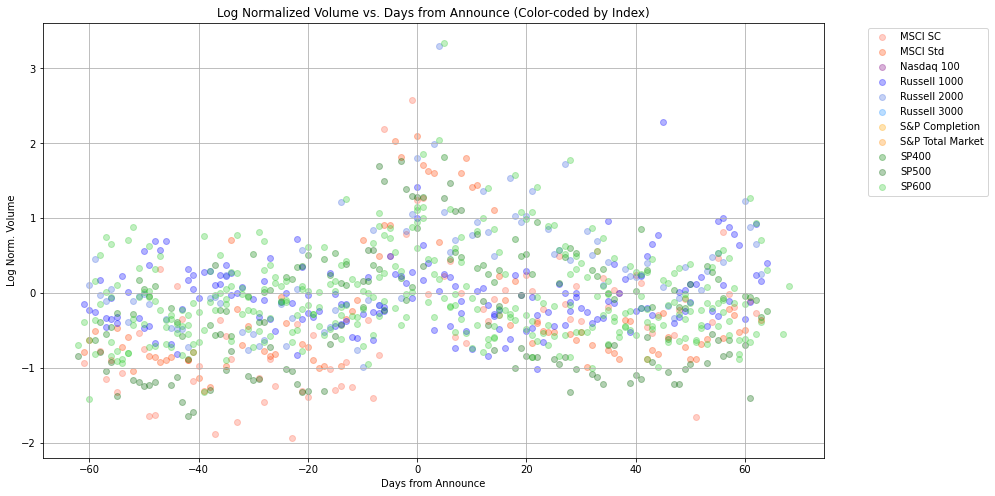

In [27]:
# Filter for 'Downweight' actions
data_down_only = data_merged[data_merged['Action'] == 'Downweight']

# Ensure no -inf, NaN, or infinite values in 'Log Normalized Volume' and 'Log Normalized Close'
data_down_only = data_down_only.replace([np.inf, -np.inf], np.nan).dropna(subset=['Log Normalized Volume', 'Log Normalized Close'])

# Reset index to plot
data_down_only = data_down_only.reset_index()

# Plot log normalized close for each ticker over time
plt.figure(figsize=(14, 8))

# Group by Ticker and plot each one
for ticker, group_data in data_down_only.groupby('Ticker'):
    plt.plot(group_data['Days from Announce'], group_data['Log Normalized Close'], label=ticker)

plt.title('Log Normalized Close Price Over Time for Each Ticker (Downweight)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Normalized Close')
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

# Define the index colors
index_colors = {
    'MSCI SC': '#FF6347',  # tomato red
    'MSCI Std': '#FF4500',  # orange red
    'Nasdaq 100': '#800080',  # purple
    'Russell 1000': '#0000FF',  # blue
    'Russell 2000': '#4169E1',  # royal blue
    'Russell 3000': '#1E90FF',  # dodger blue
    'S&P Completion': '#FFA500',  # orange
    'S&P Total Market': '#FF8C00',  # dark orange
    'SP400': '#008000',  # green
    'SP500': '#006400',  # dark green
    'SP600': '#32CD32'  # lime green
}

# Plot log normalized close for each ticker over time, color-coded by index
plt.figure(figsize=(14, 8))

# Plot the log volume difference, color-coded by indices
plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = data_down_only[data_down_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Log Normalized Close'], alpha=0.3, label=index, color=color)

plt.title('Log Normalized Close vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Norm. Close')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(14, 8))
for index, color in index_colors.items():
    subset = data_down_only[data_down_only['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Log Normalized Volume'], alpha=0.3, label=index, color=color)

plt.title('Log Normalized Volume vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Norm. Volume')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


It should be noted that in the in-sample data, there are only 13 instances of "Downweight" events.
We nevertheless try to elimate a notable outlier:

In [28]:
# Filter for 'Downweight' actions with outliers
data_down_only_outlier = data_down_only[data_down_only['Log Normalized Close'] > 0.6]

# Identify unique tickers with outliers
print(data_down_only_outlier['Ticker'].unique())
#IMVT, it is an equity offering and float update

# Ticker ESPR, it is an equity offering event
tickers_to_kick = data_down_only_outlier['Ticker'].unique()

# Clean the data by removing identified outliers
data_down_only_price_clean = data_down_only[~data_down_only['Ticker'].isin(tickers_to_kick)]

['IMVT']


In [29]:
# Set the multiindex for panel data
if not {'Ticker', 'Days from Announce'}.issubset(data_down_only_price_clean.index.names):
    data_down_only_price_clean = data_down_only_price_clean.set_index(['Ticker', 'Days from Announce'])

# Create dummy variables for each index
index_dummies = pd.get_dummies(data_down_only_price_clean['Index'], prefix='Index')

# Create dummy variables multiplied by 'Days from Announce Binary'
index_dummies_announce = index_dummies.copy()
index_dummies_announce.columns = [col + '_Announce' for col in index_dummies_announce.columns]
for col in index_dummies_announce.columns:
    index_dummies_announce[col] = index_dummies[col.replace('_Announce', '')] * data_down_only_price_clean['Days from Announce Binary']

# Create dummy variables multiplied by 'Days from Trade Binary'
index_dummies_trade = index_dummies.copy()
index_dummies_trade.columns = [col + '_Trade' for col in index_dummies_trade.columns]
for col in index_dummies_trade.columns:
    index_dummies_trade[col] = index_dummies[col.replace('_Trade', '')] * data_down_only_price_clean['Days from Trade Binary']

In [30]:
# Define the dependent and independent variables for Log Normalized Close
y_close = data_down_only_price_clean['Log Normalized Close']

# Update X_close to include index_dummies
X_close = pd.concat([index_dummies_announce, index_dummies_trade], axis=1)
X_close = sm.add_constant(X_close)

# Function to calculate VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Calculate VIF for the variables in X_close
vif_data = calculate_vif(X_close)

# Check for columns with NaN values in VIF
nan_vif_columns = vif_data[vif_data["VIF"].isna()]["Variable"].tolist()
print(f"Columns with NaN VIF: {nan_vif_columns}")

# Drop columns with NaN VIF from X_close
X_close = X_close.drop(columns=nan_vif_columns)

# Fit the fixed effects model for Log Normalized Close
model_close = PanelOLS(y_close, X_close, entity_effects=True)
results_close = model_close.fit()

print(results_close)

Columns with NaN VIF: []
                           PanelOLS Estimation Summary                            
Dep. Variable:     Log Normalized Close   R-squared:                        0.3683
Estimator:                     PanelOLS   R-squared (Between):              0.7441
No. Observations:                   856   R-squared (Within):               0.3683
Date:                  Fri, Aug 02 2024   R-squared (Overall):              0.5103
Time:                          20:30:16   Log-likelihood                    913.94
Cov. Estimator:              Unadjusted                                           
                                          F-statistic:                      40.619
Entities:                             8   P-value                           0.0000
Avg Obs:                         107.00   Distribution:                  F(12,836)
Min Obs:                         83.000                                           
Max Obs:                         173.00   F-statistic (robust)

Noticably, little to no effects due to large std. errors. We once again note that there are only 8 tickers after data cleaning.
But we should be able to take a short position shortly after announcement, and a long position for longer period (?)

In [31]:
# Define the dependent and independent variables for Log Normalized Volume
y_volume = data_down_only_price_clean['Log Normalized Volume']

# Fit the fixed effects model for Log Normalized Volume
model_volume = PanelOLS(y_volume, X_close, entity_effects=True)
results_volume = model_volume.fit()

print(results_volume)

                            PanelOLS Estimation Summary                            
Dep. Variable:     Log Normalized Volume   R-squared:                        0.1539
Estimator:                      PanelOLS   R-squared (Between):              0.2174
No. Observations:                    856   R-squared (Within):               0.1539
Date:                   Fri, Aug 02 2024   R-squared (Overall):              0.1676
Time:                           20:31:10   Log-likelihood                   -733.67
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      12.672
Entities:                              8   P-value                           0.0000
Avg Obs:                          107.00   Distribution:                  F(12,836)
Min Obs:                          83.000                                           
Max Obs:                          173.00   F-statistic (robust):            

# 6 Price and Volume Effects under Reclassification (e.g. SP400 to SP500)

We now look at the entries related to Index reclassifications, such as "SP400 to SP500", "SP500 to SP600", and so on. 

Intuition would suggest that since SP500 index funds have a larger following, reclassifying to SP500 may lead to price increase.
On the other hand, reclassification to a larger cap may suggest that the company is growing, so the causal direction is not clear.

In [32]:
# Filter for actions that indicate index changes
reclassify_action_patterns = data_merged['Action'].str.contains(' to ', case=False, na=False)
filtered_price_data_df = data_merged.loc[reclassify_action_patterns]

# Drop duplicates based on 'Date', 'Ticker', 'Action', and 'Close' columns
reclassify_data_df = filtered_price_data_df.drop_duplicates(subset=['Date', 'Ticker', 'Action', 'Close'])

# # Display the resulting dataframe
# reclassify_data_df.head(), reclassify_data_df.shape

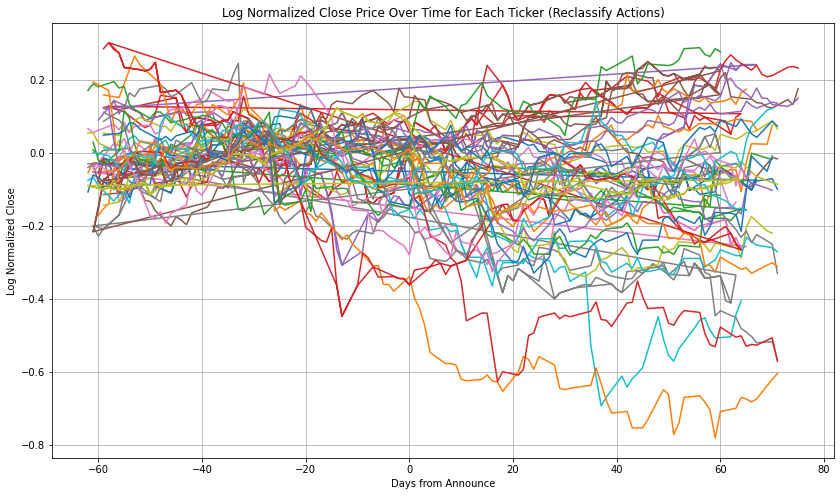

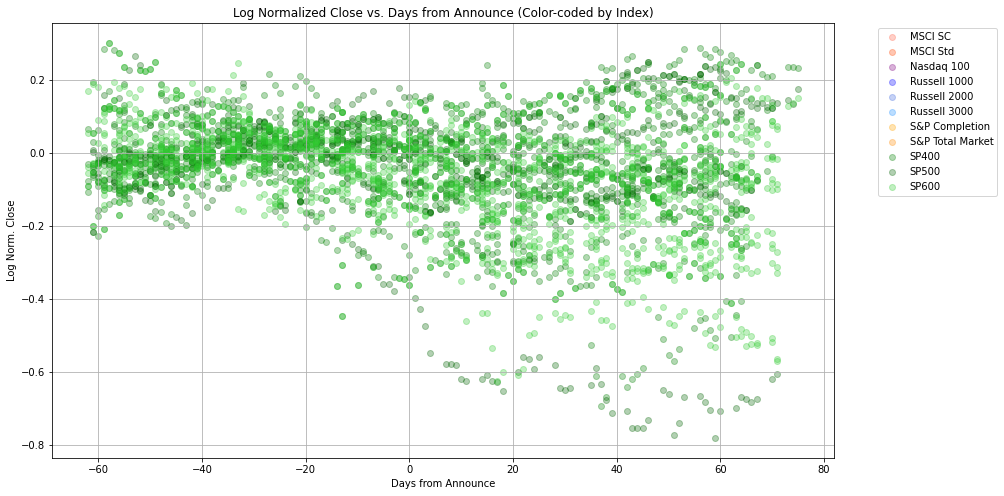

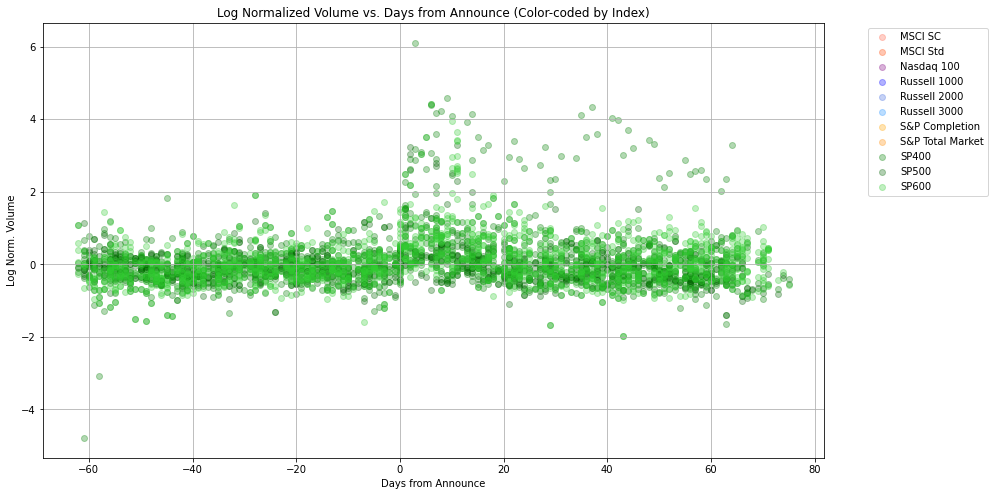

In [33]:
# Ensure no -inf, NaN, or infinite values in 'Log Normalized Volume' and 'Log Normalized Close'
reclassify_data_df = reclassify_data_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Log Normalized Volume', 'Log Normalized Close'])

# Reset index to plot
reclassify_data_df = reclassify_data_df.reset_index(drop=True)

# Plot log normalized close for each ticker over time
plt.figure(figsize=(14, 8))

# Group by Ticker and plot each one
for ticker, group_data in reclassify_data_df.groupby('Ticker'):
    plt.plot(group_data['Days from Announce'], group_data['Log Normalized Close'], label=ticker)

plt.title('Log Normalized Close Price Over Time for Each Ticker (Reclassify Actions)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Normalized Close')
plt.grid(True)
plt.show()

# Define the index colors
index_colors = {
    'MSCI SC': '#FF6347',  # tomato red
    'MSCI Std': '#FF4500',  # orange red
    'Nasdaq 100': '#800080',  # purple
    'Russell 1000': '#0000FF',  # blue
    'Russell 2000': '#4169E1',  # royal blue
    'Russell 3000': '#1E90FF',  # dodger blue
    'S&P Completion': '#FFA500',  # orange
    'S&P Total Market': '#FF8C00',  # dark orange
    'SP400': '#008000',  # green
    'SP500': '#006400',  # dark green
    'SP600': '#32CD32'  # lime green
}

# Plot log normalized close for each ticker over time, color-coded by index
plt.figure(figsize=(14, 8))

for index, color in index_colors.items():
    subset = reclassify_data_df[reclassify_data_df['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Log Normalized Close'], alpha=0.3, label=index, color=color)

plt.title('Log Normalized Close vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Norm. Close')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(14, 8))

for index, color in index_colors.items():
    subset = reclassify_data_df[reclassify_data_df['Index'] == index]
    plt.scatter(subset['Days from Announce'], subset['Log Normalized Volume'], alpha=0.3, label=index, color=color)

plt.title('Log Normalized Volume vs. Days from Announce (Color-coded by Index)')
plt.xlabel('Days from Announce')
plt.ylabel('Log Norm. Volume')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


(This time I won't be eliminating outliers, since I am not sure if there is clear indications that they are departures from normal patterns.)

Now instead of index dummies, we use action dummies, as these represent changes between two indices:

In [34]:
# Set the multiindex for panel data
if not {'Ticker', 'Days from Announce'}.issubset(reclassify_data_df.index.names):
    reclassify_data_df = reclassify_data_df.set_index(['Ticker', 'Days from Announce'])

# Create dummy variables for each action
action_dummies = pd.get_dummies(reclassify_data_df['Action'], prefix='Action')

# Create dummy variables multiplied by 'Days from Announce Binary'
action_dummies_announce = action_dummies.copy()
action_dummies_announce.columns = [col + '_Announce' for col in action_dummies_announce.columns]
for col in action_dummies_announce.columns:
    action_dummies_announce[col] = action_dummies[col.replace('_Announce', '')] * reclassify_data_df['Days from Announce Binary']

# Create dummy variables multiplied by 'Days from Trade Binary'
action_dummies_trade = action_dummies.copy()
action_dummies_trade.columns = [col + '_Trade' for col in action_dummies_trade.columns]
for col in action_dummies_trade.columns:
    action_dummies_trade[col] = action_dummies[col.replace('_Trade', '')] * reclassify_data_df['Days from Trade Binary']

In [35]:
# Define the dependent and independent variables for Log Normalized Close
y_close = reclassify_data_df['Log Normalized Close']

# Update X_close to include action_dummies
X_close = pd.concat([action_dummies_announce, action_dummies_trade], axis=1)
X_close = sm.add_constant(X_close)

# Fit the fixed effects model for Log Normalized Close
model_close = PanelOLS(y_close, X_close, entity_effects=True)
results_close = model_close.fit()

print(results_close)

                           PanelOLS Estimation Summary                            
Dep. Variable:     Log Normalized Close   R-squared:                        0.2368
Estimator:                     PanelOLS   R-squared (Between):              0.3241
No. Observations:                  4233   R-squared (Within):               0.2368
Date:                  Fri, Aug 02 2024   R-squared (Overall):              0.2743
Time:                          20:31:44   Log-likelihood                    3569.6
Cov. Estimator:              Unadjusted                                           
                                          F-statistic:                      129.70
Entities:                            42   P-value                           0.0000
Avg Obs:                         100.79   Distribution:                 F(10,4181)
Min Obs:                         48.000                                           
Max Obs:                         150.00   F-statistic (robust):             129.70
    

As intuition would suggest, moving to larger cap (SP500) seem to have a positive, albeit mild effect, while moving to smaller caps is associated with a negative effect, especially from SP500 to SP600. It also seems that announcements themselves have weak to no effect on price, except for "SP500 to SP600". It should be noted however that there are only one such instance in the in-sample period.

But again, it should be highlighted that the causality direction in the short term may not be so clear.  

# 7 Tentative Conclusion and Strategy Plans

From our fixed effect models, we tentatively formulate our trading strategy:

    1. For "Add" action, we short the stock after announcement, then cover after trading dates;
    2. For "Delete" action, we long the stock after announcement, then sell after trading dates;
    3. For both "Upweight" and "Downweight" actions, we hold no position;
    4. For reclassification into SP500, we short the stock, then cover after trading dates.
    
The next notebook examines the ideal holding periods for these strategies.